# Prepare data

In [2]:
USE_SUBSET = False

In [1]:
import pandas as pd
import glob
from fastai.vision.all import *

In [3]:
df_articles = pd.read_csv("Rawdata/articles.csv")
df_articles["article_id"] = df_articles["article_id"].astype(str)
df_articles["article_id"] = '0' + df_articles["article_id"]

In [4]:
# construct a df with the image path and the article id
img_files_raw = glob.glob('Rawdata/**/*.jpg', recursive=True)
df_paths = pd.DataFrame({"path" :img_files_raw})
df_paths["article_id"] = df_paths["path"].str[-14:].str.replace(".jpg", "", regex=False)

In [5]:
# add the imagepath to the article df
df_articles = df_articles.merge(df_paths, on='article_id', how='inner')
df_articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,path
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,Rawdata/images/010/0108775015.jpg
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,Rawdata/images/010/0108775044.jpg
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,Rawdata/images/010/0108775051.jpg
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.",Rawdata/images/011/0110065001.jpg
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.",Rawdata/images/011/0110065002.jpg


# Get relevant product groups

In [6]:
counts = df_articles["product_group_name"].value_counts()
counts

Garment Upper body       42680
Garment Lower body       19770
Garment Full body        13276
Accessories              11005
Underwear                 5462
Shoes                     5156
Swimwear                  3125
Socks & Tights            2431
Nightwear                 1898
Unknown                    121
Underwear/nightwear         54
Cosmetic                    48
Bags                        25
Items                       17
Furniture                   13
Garment and Shoe care        9
Stationery                   5
Interior textile             3
Fun                          2
Name: product_group_name, dtype: int64

In [21]:
relevant_product_groups = counts[counts > 11000].index.to_list()
print(relevant_product_groups)

['Garment Upper body', 'Garment Lower body', 'Garment Full body', 'Accessories']


In [8]:
df_articles = df_articles[df_articles["product_group_name"].isin(relevant_product_groups)]

# Prepare a final pandas dataframe

In [9]:
df = df_articles[["article_id", "product_code", "product_group_name", "path"]]
df.head()

,article_id,product_code,product_group_name,path
0,0108775015,108775,Garment Upper body,Rawdata/images/010/0108775015.jpg
1,0108775044,108775,Garment Upper body,Rawdata/images/010/0108775044.jpg
2,0108775051,108775,Garment Upper body,Rawdata/images/010/0108775051.jpg
3,0110065001,110065,Underwear,Rawdata/images/011/0110065001.jpg
4,0110065002,110065,Underwear,Rawdata/images/011/0110065002.jpg


# Classification

In [36]:
if USE_SUBSET:
  df = df.groupby('product_group_name', group_keys=False).apply(lambda x: x.sample(4)) 

In [10]:
# refactor to functions if we want to serialize the learner later
dblock = DataBlock(
  blocks = (ImageBlock, CategoryBlock),
  splitter = RandomSplitter(valid_pct=0.2, seed=42),
  get_x = lambda r: r["path"], 
  get_y = lambda r: r["product_group_name"],
  item_tfms = RandomResizedCrop(128),
  batch_tfms = aug_transforms()
)

In [12]:
dls = dblock.dataloaders(df, bs=64)

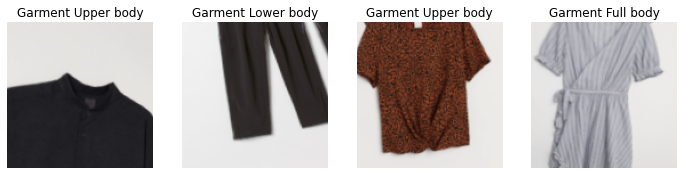

In [13]:
dls.train.show_batch(ncols = 4, nrows = 1)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

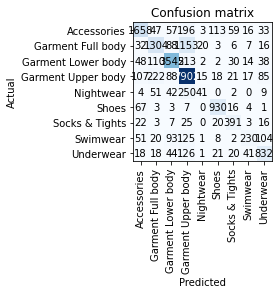

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

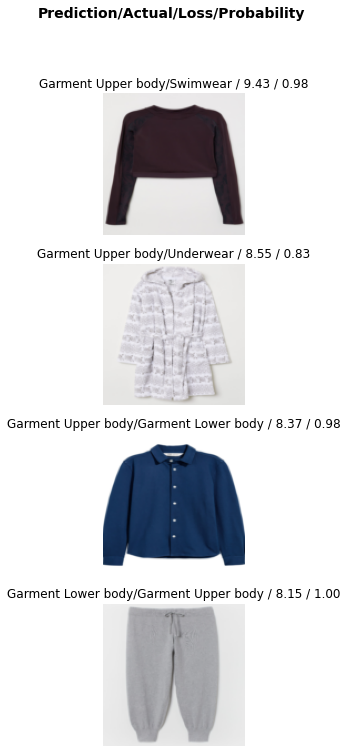

In [20]:
interp.plot_top_losses(4, nrows=4)